# Visualization of Coronavirus Spread

## Overview

1. Read the downloaded datafiles into dataframe.
1. Create a unique location key.
1. Separate readings into a timeseries by location.
1. Resample to get daily readings and forward fill missing data.
1. Merge with geodata and plot

## Read the data files

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas
import numpy as np
import glob
from datetime import datetime
from geodata_functions import *
import re

#Generate inline plots
%matplotlib inline

files = [f for f in glob.glob("./data/csse_*.csv")]

dfs = []
columns = ['Province/State','Country/Region','Last Update','Confirmed']
for f in files:
    df = pd.read_csv(f,parse_dates=['Last Update'],usecols=columns)
    dfs.append(df)
    
    
df = pd.concat(dfs); df

,Province/State,Country/Region,Last Update,Confirmed
0,Hubei,Mainland China,2020-01-31 14:00:00,5806.0
1,Zhejiang,Mainland China,2020-01-31 14:00:00,538.0
2,Guangdong,Mainland China,2020-01-31 14:00:00,436.0
3,Henan,Mainland China,2020-01-31 14:00:00,352.0
4,Hunan,Mainland China,2020-01-31 14:00:00,332.0
...,...,...,...,...
62,"Los Angeles, CA",US,2020-02-01 19:53:00,1.0
63,"Orange, CA",US,2020-02-01 19:53:00,1.0
64,"Santa Clara, CA",US,2020-02-01 19:53:00,1.0
65,"Seattle, WA",US,2020-02-01 19:43:00,1.0


## Clean the data

The data format changes over time, so we need to clean it a little. Specifically, we need to rename instances of the country UK to "United Kingdom". Then we need to convert instances of a US city, state (e.g. Chicago, IL) back to just a state.

In [58]:
# correct UK to United Kingdom
uk_idx = df['Country/Region'] == 'UK'
df.loc[uk_idx, 'Country/Region'] = 'United Kingom'

# convert state abbreviations to names
regex = r'^((?:\w+[ \-]?){1,4}), ([A-Z]{,2})$'
def city_state_to_state(row):
    text = row['Province/State']
    if pd.isna(text):
        return text
    
    match = re.match(regex, text)
    if match is None:
        return text
    group = match.groups()
    state = states_abbr_to_full[group[1]]
    return state

df['Province/State'] = df.apply(city_state_to_state, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 0 to 66
Data columns (total 4 columns):
Province/State    1364 non-null object
Country/Region    1800 non-null object
Last Update       1800 non-null datetime64[ns]
Confirmed         1770 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 70.3+ KB


### Location Key

Create a new colutm called `Location` to use as a grouping key. See the `create_location` function in `geodata_functions.py`.

In [59]:
df['Location'] = df.apply(create_location, axis=1)
locations = df['Location'].unique().tolist()
len(locations)

77

### Date Range

Create a range of dates covering the first and last readings. We will use this to creat individual time series per location.

In [60]:
dates = df['Last Update'].unique().tolist()
dates.sort()

date_rng = pd.date_range(start=dates[0], end=dates[len(dates)-1], freq='D')
date_rng

DatetimeIndex(['2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04'],
              dtype='datetime64[ns]', freq='D')

### Timeseries

Build a time series for each `Location` using the dates in `date_rng`. We will forward fill values from the last reading. Values prior to the first reading will be `NaN`. This will give us a `Confirmed` reading for every day for every location starting with the first reading for each location.

*note* Forward filling is a big assumption. There are some things I don't know about the data. For instance, if there is no `Confirmed` count update for a given location, does that mean the count has gone to zero? Or does it just mean we don't know. For this analysis I am assuming the `Confirmed` count is unchanged unless it is specifically updated to a new value.

In [61]:
location_timeseries = {}
location_details = {}
for location in locations:
    values = df[df['Location'] == location]
    ldf = values.set_index('Last Update').resample('D').mean()
    ldf = ldf.reindex(index=date_rng)
    location_timeseries[location] = ldf.fillna(method='ffill')
    #location_timeseries[location] = ldf.interpolate()
    location_details[location] = {
        'Province/State':values.iloc[0]['Province/State'], 
        'Country/Region':values.iloc[0]['Country/Region']}
    
location_timeseries['Japan']

,Confirmed
2020-01-21,1.000000
2020-01-22,2.000000
2020-01-23,1.000000
2020-01-24,2.000000
2020-01-25,2.000000
2020-01-26,4.000000
2020-01-27,4.000000
2020-01-28,7.000000
2020-01-29,8.333333
2020-01-30,11.000000


### Combined DataFrame

Build a single, large DataFrame for `Confirmed` cases with the dates as the index and the `Location`s as column names.

In [62]:
daily_confirmed = pd.DataFrame(index=date_rng,columns=locations)

for location in locations:
    daily_confirmed[location] = location_timeseries[location]
    
daily_confirmed[['Russia','Japan','Hong Kong, Hong Kong','Hubei, Mainland China']]


,Russia,Japan,"Hong Kong, Hong Kong","Hubei, Mainland China"
2020-01-21,NaN,1.000000,NaN,270.000000
2020-01-22,NaN,2.000000,NaN,444.000000
2020-01-23,NaN,1.000000,2.000000,444.000000
2020-01-24,NaN,2.000000,2.000000,549.000000
2020-01-25,NaN,2.000000,5.000000,847.333333
2020-01-26,NaN,4.000000,8.000000,1240.500000
2020-01-27,NaN,4.000000,8.000000,1853.333333
2020-01-28,NaN,7.000000,8.000000,3274.000000
2020-01-29,NaN,8.333333,10.000000,3898.000000
2020-01-30,NaN,11.000000,11.000000,5354.500000


### View the data

The combinded `daily_confirmed` DataFrame is handy, but we need a convenient way to get the daily readings for all locations. We then need to bring back the `Province/State` and `Country/Region` to join with the Geopandas DataFrame.

In [63]:
def build_df_for_datetime(d):
    day_df = pd.DataFrame(daily_confirmed.loc[d])
    day_df.columns = ['Confirmed']
    day_df[['Province/State','Country/Region']] = day_df.apply(lambda x: pd.Series(location_details[x.name]), axis=1)
    day_df.dropna(subset=['Confirmed'], inplace=True)
    return day_df

d = date_rng[0]
day_df = build_df_for_datetime(d)
day_df

,Confirmed,Province/State,Country/Region
"Hubei, Mainland China",270.0,Hubei,Mainland China
"Zhejiang, Mainland China",5.0,Zhejiang,Mainland China
"Guangdong, Mainland China",17.0,Guangdong,Mainland China
"Henan, Mainland China",1.0,Henan,Mainland China
"Hunan, Mainland China",1.0,Hunan,Mainland China
"Jiangxi, Mainland China",2.0,Jiangxi,Mainland China
"Chongqing, Mainland China",5.0,Chongqing,Mainland China
"Shandong, Mainland China",1.0,Shandong,Mainland China
"Sichuan, Mainland China",2.0,Sichuan,Mainland China
"Beijing, Mainland China",10.0,Beijing,Mainland China


## GeoDataFrame

Merge a single day of data with the GeoPandas data. See `build_ncov_geodf` in `geodata_functions.py`.

In [64]:
ncov = build_ncov_geodf(day_df)
ncov[['name','Confirmed','geometry']].sort_values(by='Confirmed', ascending=False).head()

,name,Confirmed,geometry
8,Hubei,270.0,"MULTIPOLYGON (((109.46048 29.55436, 109.45979 ..."
6,Guangdong,17.0,"MULTIPOLYGON (((110.58903 20.37208, 110.58903 ..."
4,Beijing,10.0,"MULTIPOLYGON (((116.23775 39.51794, 116.23721 ..."
17,Beijing,10.0,"MULTIPOLYGON (((116.23775 39.51794, 116.23721 ..."
12,Shanghai,9.0,"MULTIPOLYGON (((121.70236 30.55958, 121.70236 ..."


## Plot the first day

Build a baseline world map and then layer the day 1 data

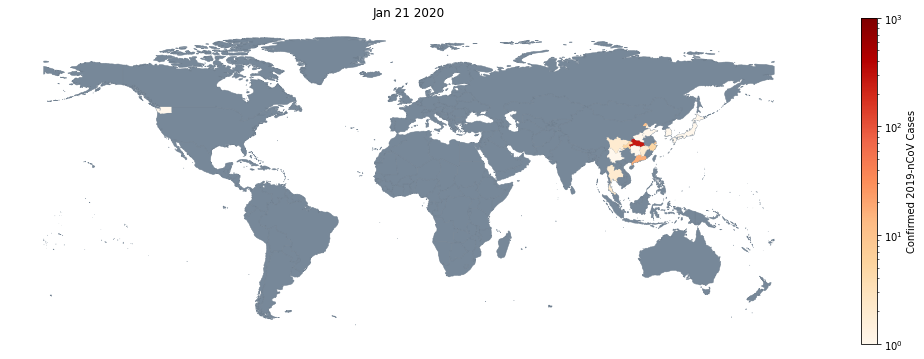

In [65]:
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

world_lines = geopandas.read_file('zip://./shapefiles/ne_50m_admin_0_countries.zip')
world = world_lines[(world_lines['POP_EST'] > 0) & (world_lines['ADMIN'] != 'Antarctica')]

fig, ax = plt.subplots(figsize=(18, 6))

world.plot(
    ax=ax,
    color = "lightslategray", 
    edgecolor = "slategray", 
    linewidth = 0.5);
ax.axis('off')

ax.set_title(d.strftime("%b %d %Y"))
ncov = build_ncov_geodf(day_df)

ncov.plot(
    ax=ax, 
    column='Confirmed', 
    norm=colors.LogNorm(vmin=1, vmax=1000),
    legend=True,
    legend_kwds={'label': "Confirmed 2019-nCoV Cases"},
    cmap='OrRd')

## Plot the most recent day

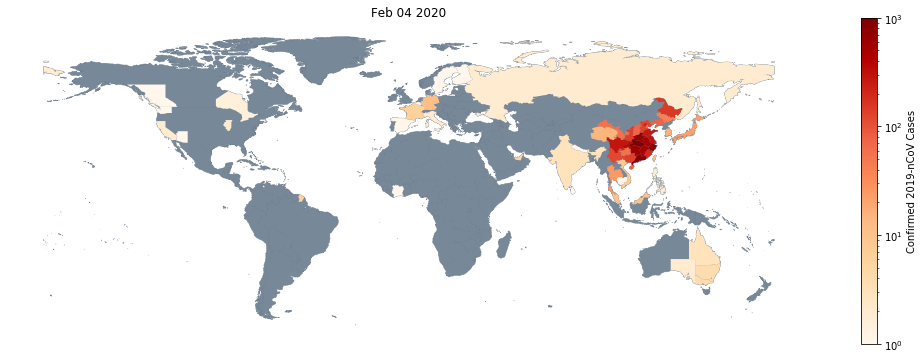

In [66]:
fig, ax = plt.subplots(figsize=(18, 6))

world.plot(
    ax=ax,
    color = "lightslategray", 
    edgecolor = "slategray", 
    linewidth = 0.5);
ax.axis('off')

d = date_rng[len(date_rng)-1]
ax.set_title(d.strftime("%b %d %Y"))
day_df = build_df_for_datetime(d)
ncov = build_ncov_geodf(day_df)

ncov.plot(
    ax=ax, 
    column='Confirmed', 
    norm=colors.LogNorm(vmin=1, vmax=1000),
    legend=True,
    legend_kwds={'label': "Confirmed 2019-nCoV Cases"},
    cmap='OrRd')

## Generate image files

Loop over all dates and export as image files.

To generate a an animated GIF, run

```sh
cd out
convert -delay 75 *.png ncov.gif
```

for a version that fits nicely on Twitter
```sh
convert -background "rgba(112,128,144,1)" -resize 1200x628 -gravity center -extent 1200x628 -delay 75 *.png ncov.gif
```

In [69]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

def output_images():
    i = 0
    for date in date_rng:
        fig, ax = plt.subplots(figsize=(18, 6))

        world.plot(
            ax=ax,
            color = "lightslategray", 
            edgecolor = "slategray", 
            linewidth = 0.5);

        ax.axis('off')

        d = date
        ax.set_title(d.strftime("%b %d %Y"))
        day_df = build_df_for_datetime(d)
        ncov = build_ncov_geodf(day_df)

        ncov.plot(
            ax=ax, 
            column='Confirmed', 
            norm=colors.LogNorm(vmin=1, vmax=1000),
            legend=True,
            legend_kwds={'label': "Confirmed 2019-nCoV Cases"},
            cmap='OrRd')

        i += 1
        fig.savefig('./out/' + '{0:03d}'.format(i) + '.png', facecolor='slategrey', dpi=150, bbox_inches='tight')
        
#uncomment to save imaages locally
#output_images()